The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_PRTR/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


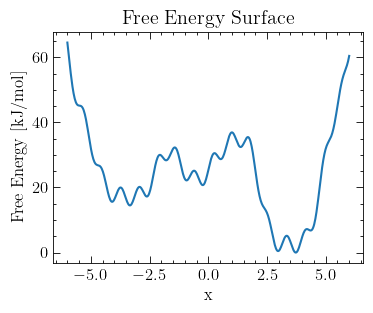

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.interpolate import interp1d

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_PRTR"): print("\nThe data folder \"_data_PRTR\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_PRTR/"); 
    path_data = path_notebook + "/_data_PRTR/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})

# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 4
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

In [14]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

### Define default parameters

In [5]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":y_string, "pl_grid":pl_x, "position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":True, "bootstrap_iter":50,
     				"simulation_folder_path": path_data, "print_info": True}

### Run test PRTR (Parallel Real-Time ReInitialisation) simulation


Loading simulation folder: simulation_test_1
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms without external bias. 

Loading simulation folder: simulation_test_2
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms without external bias. 

Loading simulation folder: simulation_test_3
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms without external bias. 

Loading simulation folder: simulation_test_4
testing loading data from hills, pos and external_bias.dat. Remove 1==2 to try to load force terms
force terms file not found. Calculating force terms with external bias. 

Loading simulation folder: simulation_test_5
testing loading data from hills, pos and external_bias.dat. Remove 1==2 t

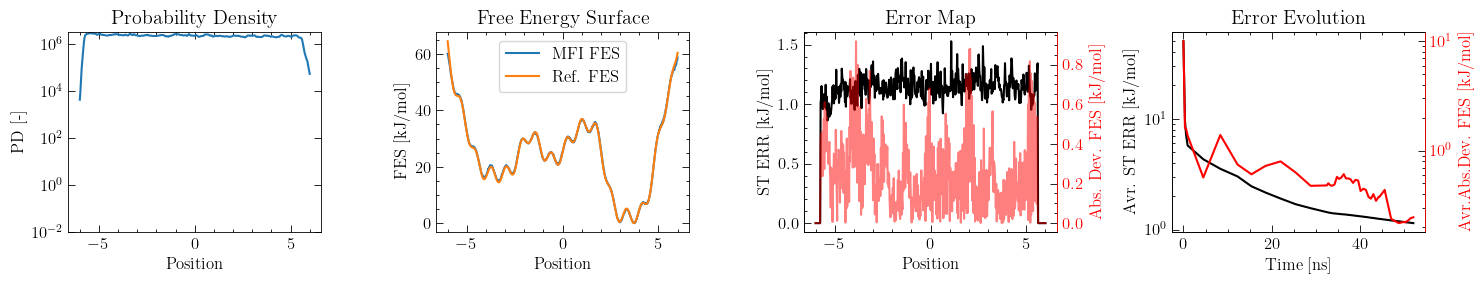


~~~~~~ END ~~~~~~

mfi_PRTR.sim[0].Aofe = 1.1454, mfi_PRTR.sim[0].AAD = 0.2454


In [15]:
# Prepare the MFI object
MFI = MFI_class1D.MFI1D(**default_params)

# Prepare the parallel real-time analysis and re-initialisation object
mfi_PRTR = MFI.MFI_parallel_RTR(parent=MFI, ID="_test", workers=3, goal=0.01, main_error_type="AAD", n_pos_before_analysis=500, 
                                guaranteed_sim_time=4, max_sim_time=6, ### time units [ns] , with metad_pace=500 -> 1ns ~ 400 hills
                                # time_budget=10 )  # use this for starting a SRTR-campaign for 0 ns.  
								restart_PRTR=True, time_budget=50)  # use this for re-starting a PRTR-campaign from existing data.

# Run the parallel real-time analysis and re-initialisation
mfi_PRTR.run()

# Plot+print the final results
mfi_PRTR.sim[0].plot_results()
print(f"\n~~~~~~ END ~~~~~~\n\n{mfi_PRTR.sim[0].Aofe = :.4f}, {mfi_PRTR.sim[0].AAD = :.4f}")


#### Usefull plots

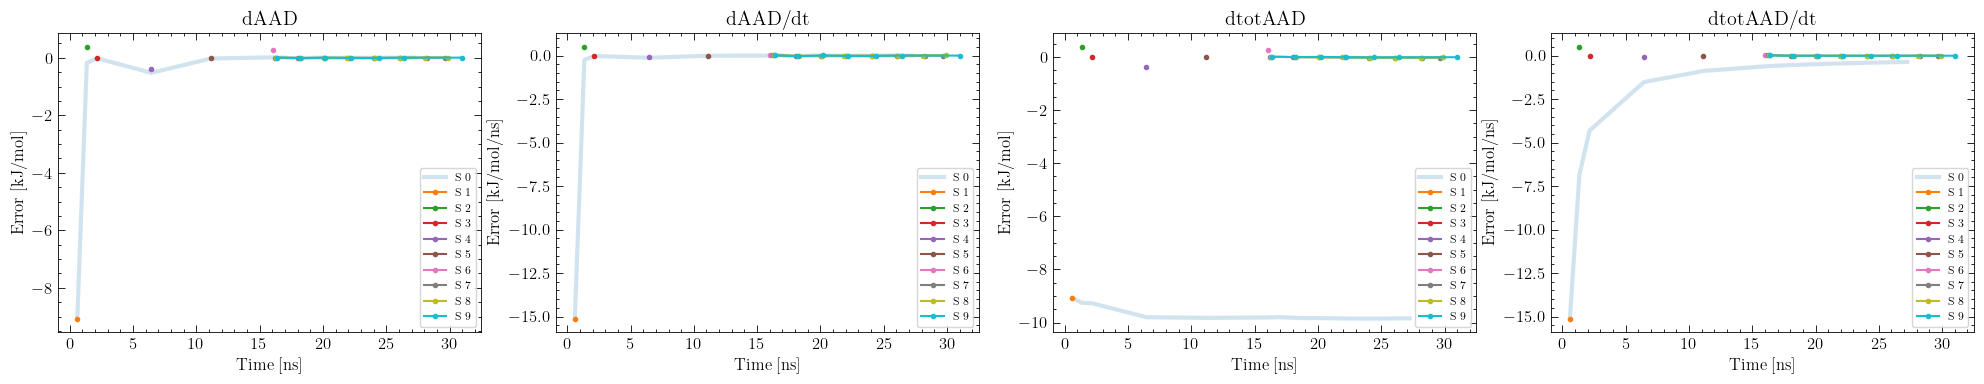

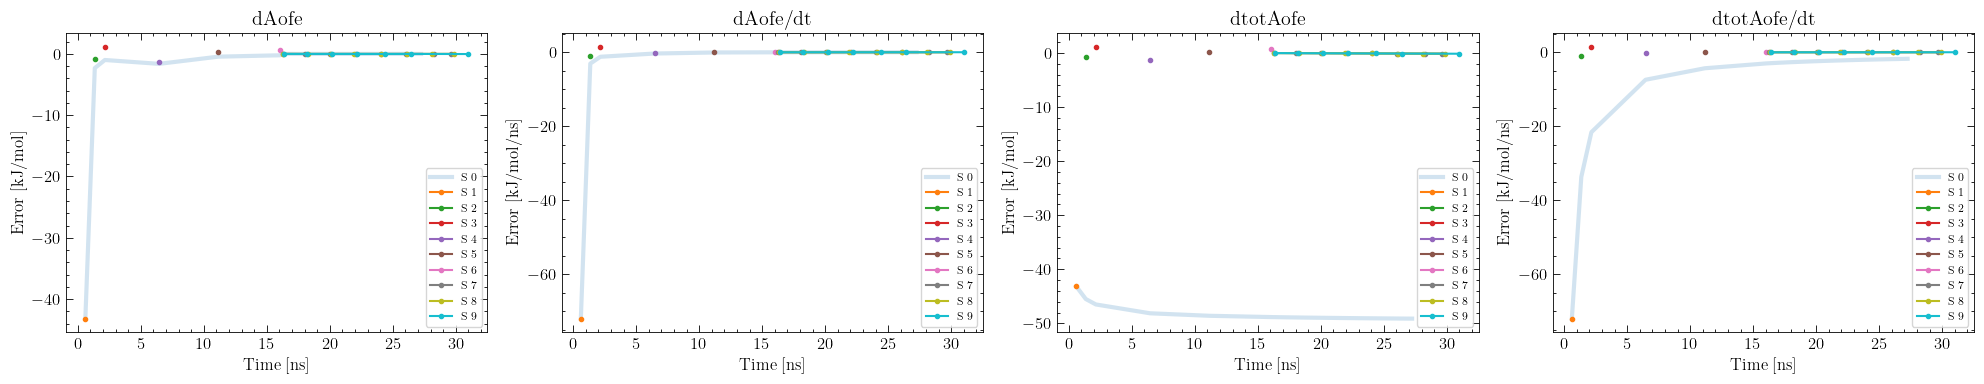

In [60]:
# plot the change in error

# aad
lib1.plot_PRTR_d_error(mfi_PRTR, plot_aad=True)

# Avr on the fly error (error of the mean force)
lib1.plot_PRTR_d_error(mfi_PRTR)

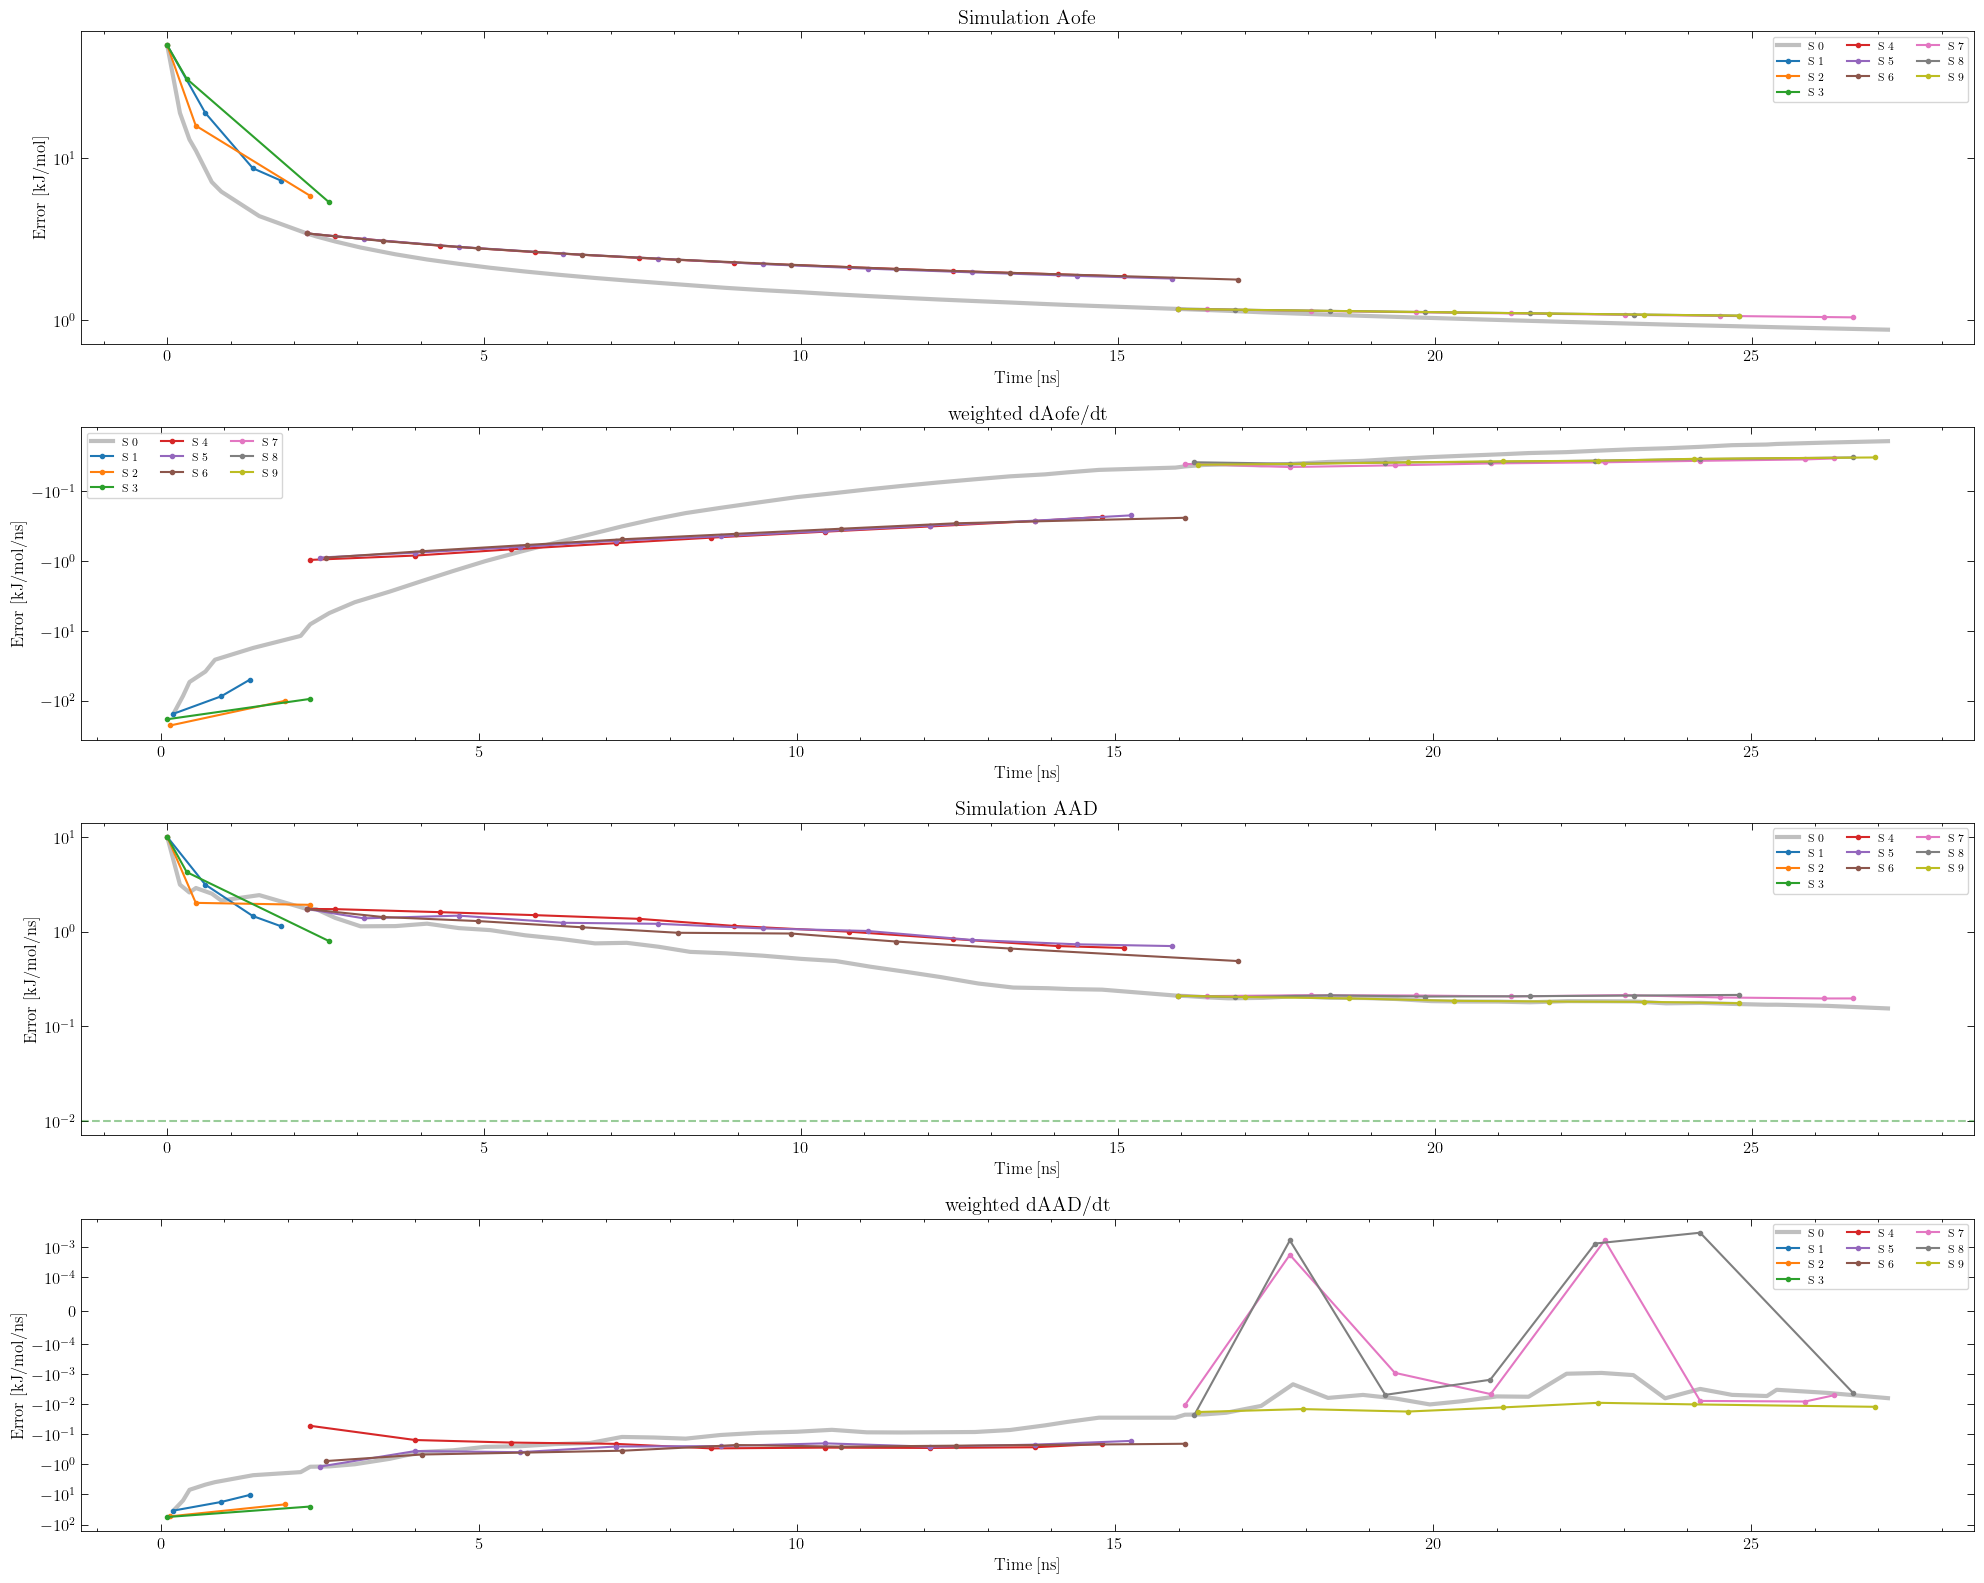

In [74]:
### Mega plot with [d_AAD_w, AAD, d_Aofe_w, Aofe]
lib1.large_error_plot(mfi_PRTR)


### Run Multiple Long Simulations and analysis (for statistical analysis)

In [6]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [1]:
# n_campaigns = 15
# min_sim_time, max_sim_time, time_budget = 10, 20, 100

# # Loop over all surfaces
# # for n_surf in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
# # for n_surf in range(20):
# for n_surf in [4]:
    
#     # Set the surface
#     y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
#     print(f"\n~~~~~~ Surface {n_surf} ~~~~~~")

#     # loop over campaigns
#     for i in range(1,n_campaigns+1):
        
#         # Set the path to the campaign folder and the campaign ID
#         print(f"~~~~~~ Simulation {i} ~~~~~~")
#         new_path = path_data + f"S{n_surf}/"
#         camp_ID = f"_{i}_{time_budget}ns"
#         path_campaign = new_path + f"SRTRcampaign{camp_ID}/"
        
#         #check if directory exists. If does not exist, create it and move to it.
#         if os.path.isdir(path_campaign): pass
#         else: os.mkdir(path_campaign)
#         os.chdir(path_campaign)
        
#         # check if error progression file exists. If it does, skip this iteration, otherwise run the campaign.
# 		if os.path.isfile(path_camp + f"error_progression_SRTR{camp_ID}"): print(f"File error_progression_SRTR{camp_ID} already exists. Skipping this iteration."); continue	
# 		else: print(f"S{n_surf}: Running campaign {i} of {total_campaigns} ")    
      
#         ## Prepare MFI object
#         new_params = default_params.copy()
#         new_params.update({"simulation_folder_path":new_path, "y":y, "System":y_string, "FES_cutoff":FES_cutoff})             
#         MFI = MFI_class1D.MFI1D(**new_params)

#         # h_list = [20, 15, 10]
#         # bf_list = [50, 50, 50]
#         # sigma_list = [0.2, 0.15, 0.1]

#         mfi_PRTR = MFI.MFI_parallel_RTR(parent=MFI, workers=3, goal=0.01, goal_type="AAD", 
#                                         # metad_height_list=h_list, biasfactor_list=bf_list, metad_width_list=sigma_list, 
#                                         guaranteed_sim_time=min_sim_time, max_sim_time=max_sim_time, time_budget=time_budget)
#         mfi_PRTR.run()

        
# 		print(f"~~~~ End of campaign ~~~~\n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}\n\n")
#         err = mfi_PRTR.sim[0].Avr_Error_list
#         lib1.save_pkl( [list(mfi_PRTR.sim[0].Avr_Error_list[:, 0]), list(mfi_PRTR.sim[0].Avr_Error_list[:, 2]), list(mfi_PRTR.sim[0].Avr_Error_list[:, mfi_PRTR.sim[0].aad_index])], path_camp + f"error_progression_PRTR_{i}_100ns")
        


### Calculate and plot average error progression

t=[0.15,100.00] | Final avr: AOFE=0.473, AAD=0.069


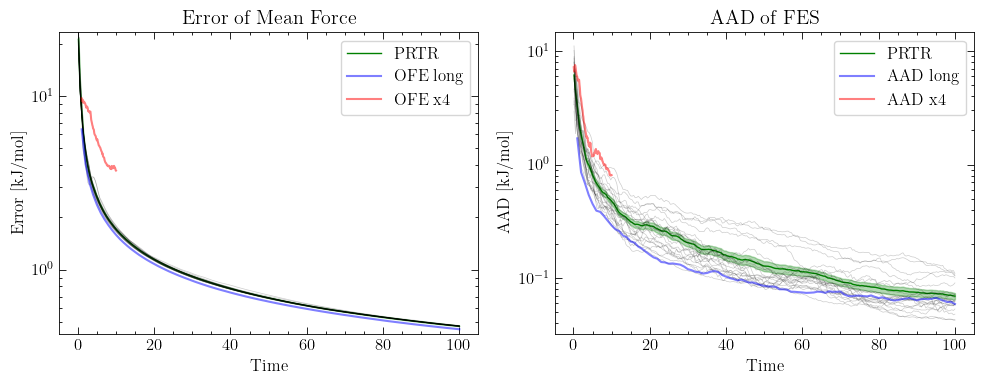

In [75]:
n_surf = 4
total_campaigns = 21
time_budget = 100

# calculate and plot the average error progression
lib1.get_avr_error_prog(path_data, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="PRTR", show_plot=False, line_label="PRTR")

# plot the average error progression of the long and 4-patallel simulations
[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_long")
[time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_x4_10ns"  )
plt.subplot(1,2,1); plt.plot(time_l, ofe_mean_l, label="OFE long", color="blue", alpha=0.5); plt.plot(time_p, ofe_mean_p, label="OFE x4", color="red", alpha=0.5); plt.legend(); 
plt.subplot(1,2,2); plt.plot(time_l, aad_mean_l, label="AAD long", color="blue", alpha=0.5); plt.plot(time_p, aad_mean_p, label="AAD x4", color="red", alpha=0.5); plt.legend(); 
plt.tight_layout(); plt.show()